# ML lab 07

# Neural Networks

In [1]:
# Uncomment to upgrade packages
# !pip install pandas --upgrade --user --quiet
# !pip install numpy --upgrade --user --quiet
# !pip install scipy --upgrade --user --quiet
# !pip install statsmodels --upgrade --user --quiet
# !pip install scikit-learn --upgrade --user --quiet
# !pip3 install graphviz --upgrade --user --quiet
# If you are in windows use: conda install python-graphviz
%load_ext autoreload

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
pd.set_option('precision', 3)
InteractiveShell.ast_node_interactivity = "all"

In [6]:
# Extra imports
from sklearn.metrics import confusion_matrix,\
                classification_report, accuracy_score
from pandas import read_csv
from sklearn.model_selection import train_test_split, cross_validate

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from graphviz import Digraph
from sklearn.model_selection import GridSearchCV
from numpy.random import normal
from numpy.random import uniform

from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from time import time
from datetime import timedelta

from sklearn.metrics import precision_score, classification_report, recall_score

from sklearn.datasets import fetch_lfw_people

np.random.seed(4567)

In [7]:
# If you are in windows and graphviz gives you error:
# import os 
# os.environ["PATH"] += os.pathsep + r"my graphviz installation path/bin"

In [8]:
def confusion(true, pred):
    """
    Function for pretty printing confusion matrices
    """
    pred = pd.Series(pred)
    true = pd.Series(true)
    
    true.name = 'target'
    pred.name = 'predicted'
    cm = pd.crosstab(true.reset_index(drop=True), pred.reset_index(drop=True))
    cm = cm[cm.index]
    return cm


def graphMLP(vars,layers,intercepts):
    """
    Function for plotting the weights of a mlp
    """
    f = Digraph('')
    f.attr(rankdir='LR')
    for i,l in enumerate(layers):
        if i==0:
            for j in range(l.shape[1]):
                for k, v in enumerate(vars):
                    f.edge(v, 'L%dN%d'%(i,j), label=str(l[k,j]))
            f.node('ILI', shape='doublecircle')                    
            for k in range(intercepts[i].shape[0]): 
                f.edge('ILI', 
                       'L%dN%d'%(i,k), 
                       label=str(intercepts[i][k]))
        else:
            for j in range(l.shape[1]):
                for k in range(layers[i-1].shape[1]):
                    f.edge('L%dN%d'%(i-1,k), 
                           'L%dN%d'%(i,j), 
                           label=str(l[k,j]))
            f.node('L%dI'%(i-1), shape='doublecircle')                  
            for k in range(intercepts[i].shape[0]):
                f.edge('L%dI'%(i-1), 
                       'L%dN%d'%(i,k), 
                       label=str(intercepts[i][k]))    
                
    return f


## SECTION 1 Admissions

We are going to use the admissions dataset for our examples on this lab. 

This dataset contains the next variables: 
* GRE (Graduate Record Exam scores)
* GPA (Grade Point Average) and
* rank (prestige of the undergraduate institution)

This variables should affect admission into a graduate school.


 The target variable, admit/don't admit, is a binary variable, which we want to characterize
and, if possible, to predict. 

In [9]:
Admis = read_csv("Admissions.csv", delimiter=',')
Admis.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


We will treat all the variables gre and gpa as continuous.

The variable rank takes on the values 1 through 4, so we can fairly treat it as numerical (although, in rigour, it is ordinal)

In [10]:
Admis.describe()

N = Admis.shape[0]

,admit,gre,gpa,rank
count,400.000,400.000,400.000,400.000
mean,0.318,587.700,3.390,2.485
std,0.466,115.517,0.381,0.944
min,0.000,220.000,2.260,1.000
25%,0.000,520.000,3.130,2.000
50%,0.000,580.000,3.395,2.000
75%,1.000,660.000,3.670,3.000
max,1.000,800.000,4.000,4.000


We first split the available data into learning and test sets, selecting randomly 2/3 and 1/3 of the data We do this for a honest estimation of prediction performance.

### Resampling protocol

This time we will use a Train and Test partitions and we will use the cross-validation score to compare the models. 

In [11]:
np.random.seed(63)
X_train, X_test, y_train, y_test =\
        train_test_split(Admis[['gre', 'gpa', 'rank']], Admis.admit, test_size=0.33,random_state=42)

### Pre-processing

We will use a simple pre-processing. Just scaling. 

In [12]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

### Choosing our metrics

This time we have an unbalanced classification problem, where it is equally important to predict correctly both classes. 
For this reason our main metric is going to be F-score macro. We are also going to check precision macro and recall macro. 

In [13]:
results_df = pd.DataFrame(index=['Logistic Regression'],
                          columns=['F-score (cv)', 'Precision (cv)','Recall (cv)', 'Accuracy (cv)'])

### Baseline: Logistic Regression

We are going to use the logistic regression as a baseline, and we will try to improve the results given by the baseline with the other models.

We are using a baseline this time because this is the Neural Networks lab, and we will be training MLPs. As you might already know, an MLP can be quite slow to train and has tons of hyperparameters, so, to be sure that we don't need hours to discover that we have done something wrong, we will use a simple model (logistic regression) as a baseline. 

In [14]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
scores = cross_val_score(logreg, X_train, y_train, cv=5)
y_pred_lr = logreg.predict(X_train)

cross_val_results = pd.DataFrame(cross_validate(logreg , X_train, y_train, cv = 5, 
                                                scoring = [ 'f1_macro', 'precision_macro', 'recall_macro', 'accuracy'] ))

results_df.loc['Logistic Regression',:] = cross_val_results[['test_f1_macro',
       'test_precision_macro', 'test_recall_macro','test_accuracy']].mean().values

confusion(y_train,y_pred_lr)
results_df

LogisticRegression()

predicted,0,1
target,,
0,171,12
1,65,20


,F-score (cv),Precision (cv),Recall (cv),Accuracy (cv)
Logistic Regression,0.554,0.686,0.568,0.698


Just with the baseline we are already obtaining a 69% of accuracy and a 0.55 of F-score. The gap between those two metrics is probably caused by the unbalance. 

Now we can check the coeficients to see if there is any strange stuff that we should fix before starting with our networks.

In [15]:
logreg.coef_
logreg.intercept_

array([[ 0.16385153,  0.35034143, -0.46349665]])

array([-0.84430907])

### Multi Layered Perceptron (Yay! Neural Networks!)

MLP is almost the simplest of the Neural Network models. This model is based on combining linearly the input of the previous layer and applying an activation function to the result over different layers. 

When it has more than a hidden layer it is called a __Deep__ Neural Network. This hidden layers give the model complexity and expresivity, but also add more weights that you will need to train.

The most important parameters of the MLP are: 
* Architecture (number of layers and number of neurons by layer). 
* Activation function. 
* alpha (regularization term).
* Solver ‘lbfgs’, ‘sgd’, ‘adam’.
* Learning rate, learning_rate_init.

As you can see, this model has many hyperparameters; if in doubt, you can look up [their meaning here](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

We are going to start with a 1 neuron dummy MLP with logistic activation function and no regularization.

In [16]:
model_nnet = MLPClassifier(hidden_layer_sizes=[1],
                           alpha=0,
                           activation='logistic',
                           max_iter=200,
                           solver='lbfgs',random_state=42)
model_nnet.fit(X_train, y_train);


y_pred = model_nnet.predict(X_train)

print('Confusion matrix of the TRAIN dataset')
confusion(y_train, y_pred)

cross_val_results = pd.DataFrame(cross_validate(model_nnet , X_train, y_train, cv = 5, 
                                                scoring = [ 'f1_macro', 'precision_macro', 'recall_macro', 'accuracy'] ))

results_df.loc['MLP[1]',:] = cross_val_results[['test_f1_macro',
       'test_precision_macro', 'test_recall_macro','test_accuracy']].mean().values

results_df.sort_values(by='F-score (cv)', ascending=False)

MLPClassifier(activation='logistic', alpha=0, hidden_layer_sizes=[1],
              random_state=42, solver='lbfgs')

Confusion matrix of the TRAIN dataset


predicted,0,1
target,,
0,171,12
1,66,19


,F-score (cv),Precision (cv),Recall (cv),Accuracy (cv)
MLP[1],0.56,0.655,0.57,0.683
Logistic Regression,0.554,0.686,0.568,0.698


We can see that this dummy mlp is already winning our other model in our main metric. Let's see how this is looking on the inside.

Here we can see this mlp weights.

In [17]:
model_nnet.coefs_
model_nnet.intercepts_

[array([[-0.05484939],
        [-0.11030314],
        [ 0.14680852]]),
 array([[-23.22637489]])]

[array([-1.58451957]), array([3.1449579])]

We can also look at it as a graph. Isn't this structure familiar?

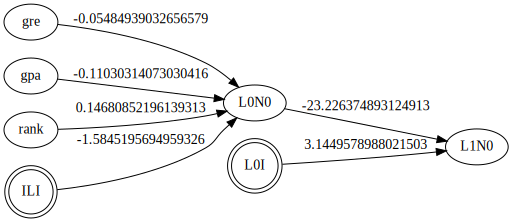

In [19]:
graphMLP(Admis.columns[1:], model_nnet.coefs_, model_nnet.intercepts_)

On this graph the gre, gpa, rank and ILI represent the input layer,which would be our training samples. 
L0N0 is our hidden neuron. L01 the extra intercept and L1N0 our output neuron. 

Now that we know what we are doing, lets make a bigger network.

In [20]:
model_nnet = MLPClassifier(hidden_layer_sizes=[2,2,2],
                           alpha=0,
                           activation='logistic',
                           max_iter=200,
                           solver='lbfgs',random_state=42)
model_nnet.fit(X_train,y_train);
y_pred = model_nnet.predict(X_train)

print('Confusion matrix of the TRAIN dataset')
confusion(y_train,y_pred)

cross_val_results = pd.DataFrame(cross_validate(model_nnet , X_train, y_train, cv = 5, 
                                                scoring = [ 'f1_macro', 'precision_macro', 'recall_macro', 'accuracy'] ))

results_df.loc['MLP[2,2,2]',:] = cross_val_results[['test_f1_macro',
       'test_precision_macro', 'test_recall_macro','test_accuracy']].mean().values

results_df.sort_values(by='F-score (cv)', ascending=False)


MLPClassifier(activation='logistic', alpha=0, hidden_layer_sizes=[2, 2, 2],
              random_state=42, solver='lbfgs')

Confusion matrix of the TRAIN dataset


predicted,0,1
target,,
0,151,32
1,48,37


,F-score (cv),Precision (cv),Recall (cv),Accuracy (cv)
"MLP[2,2,2]",0.561,0.629,0.578,0.69
MLP[1],0.56,0.655,0.57,0.683
Logistic Regression,0.554,0.686,0.568,0.698


Now our model is performing slightly better. 
Also, our model complexity is increasing, which might increase the training time. 

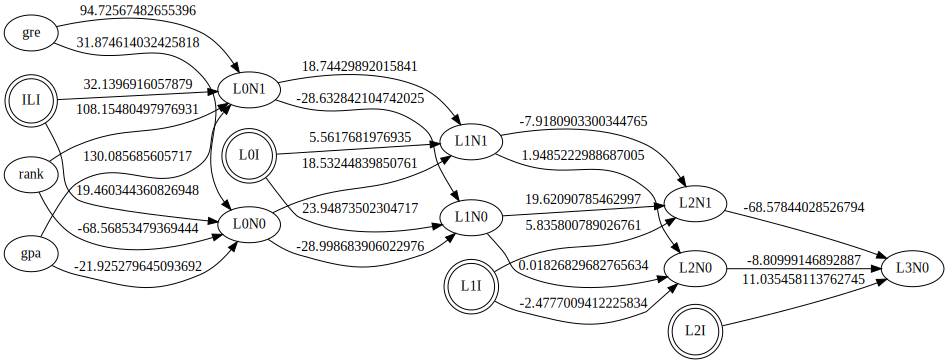

In [21]:
graphMLP(Admis.columns[1:], model_nnet.coefs_, model_nnet.intercepts_)

As you can see, some weights are large (two orders of magnitude larger then others) This is no good, since it makes the model unstable (i.e., small changes in some inputs may entail significant changes in the network, because of the large weights)

One way to avoid this is by regularizing the learning process:

In [22]:
model_nnet = MLPClassifier(hidden_layer_sizes=[2,2,2],
                           alpha=0.001,
                           activation='logistic',
                           max_iter=200,
                           solver='lbfgs',random_state=42)
model_nnet.fit(X_train,y_train);
print('Confusion matrix of the TRAIN dataset')
confusion(y_train,y_pred)

cross_val_results = pd.DataFrame(cross_validate(model_nnet , X_train, y_train, cv = 5, 
                                                scoring = [ 'f1_macro', 'precision_macro', 'recall_macro', 'accuracy'] ))

results_df.loc['MLP[2,2,2]-alpha=0.001',:] = cross_val_results[['test_f1_macro',
       'test_precision_macro', 'test_recall_macro','test_accuracy']].mean().values

results_df.sort_values(by='F-score (cv)', ascending=False)

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=[2, 2, 2],
              random_state=42, solver='lbfgs')

Confusion matrix of the TRAIN dataset


predicted,0,1
target,,
0,151,32
1,48,37


,F-score (cv),Precision (cv),Recall (cv),Accuracy (cv)
"MLP[2,2,2]",0.561,0.629,0.578,0.69
MLP[1],0.56,0.655,0.57,0.683
Logistic Regression,0.554,0.686,0.568,0.698
"MLP[2,2,2]-alpha=0.001",0.504,0.536,0.538,0.679


Now we have a model with smaller weights (more robust) but with worse performance. As you can see, just trying hyperparameter configurations is not enough to obtain a good model. If we want to succeed we need to try a lot of different configurations changing the architecture, the regularization parameter and the activation functions.

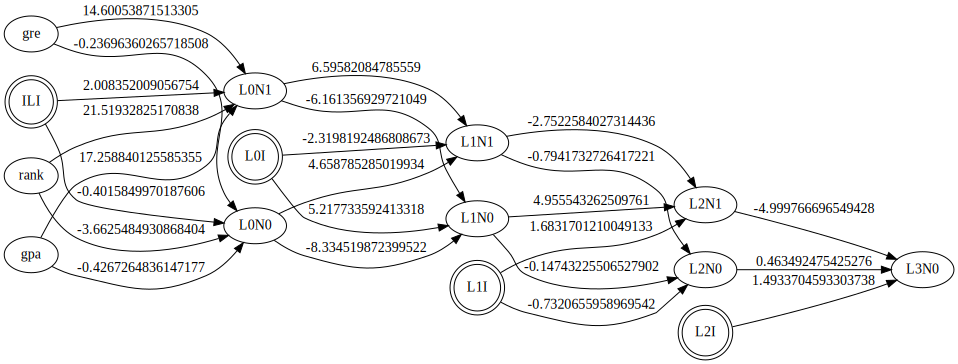

In [23]:
graphMLP(Admis.columns[1:], model_nnet.coefs_, model_nnet.intercepts_)

MLP results depend *Strongly* of its hyperparameter configuration. Now we are going to see different strategies to obtain the best hyperparameters for our model.

Scikit learn has specific functions for parameter search so we can tune the parameters of a model.

 We are going to use a grid search that will use a cross validation strategy to evaluate the results for each combination of parameters. At the end the best model will be returned

 In order to find the best network architecture, we can:

1. Explore different numbers of hidden units in one hidden layer, with the best architecture, find the best regularization. 
2. Use grid search over all the combinations of architectures and regularization values. 

Most of the times the first option is good enough in terms of results, while a lot faster than the second. 

In this particular case we will do the secon method, as we are woring with a small and easy dataset.

set desired sizes

In [24]:
sizes = [2*i for i in range(1,5)]
sizes = sizes + [[2*i,2*i] for i in range(1,5)]
sizes = sizes + [[2*i,2*i, 2*i] for i in range(1,5)]

len(sizes), sizes


decays = [0.00001,0.0001,0.001,0.01,0.1,0.5,1]
len(decays), decays[:10] 



(12,
 [2,
  4,
  6,
  8,
  [2, 2],
  [4, 4],
  [6, 6],
  [8, 8],
  [2, 2, 2],
  [4, 4, 4],
  [6, 6, 6],
  [8, 8, 8]])

(7, [1e-05, 0.0001, 0.001, 0.01, 0.1, 0.5, 1])

In [25]:
init_time=time()
model_nnet = MLPClassifier(alpha=0,
                           activation='logistic',
                           max_iter=500,
                           solver='lbfgs',
                           random_state=42)

trc = GridSearchCV(estimator=model_nnet,
                   scoring=['f1_macro', 'precision_macro', 'recall_macro', 'accuracy'],
                   param_grid={'hidden_layer_sizes': sizes,
                              'alpha': decays},
                   cv=10,
                   return_train_score=True,
                   refit='f1_macro')

model_10CV = trc.fit(X_train, y_train)
print(timedelta(seconds=(time()-init_time)))

0:00:58.961832


Now we can use the results of the cv to decide which is the best parameter configuration.

According to the criteria of having the greatest F-score, the winner is architecture layers [2,2]

In [26]:
pd.DataFrame(model_10CV.cv_results_).loc[:,['param_alpha','param_hidden_layer_sizes',  'mean_test_f1_macro', 
                                            'std_test_f1_macro','mean_test_precision_macro', 'std_test_precision_macro',
                                        'mean_test_accuracy','std_test_accuracy',]].sort_values(by='mean_test_f1_macro',
                                                                                                ascending=False).head()

,param_alpha,param_hidden_layer_sizes,mean_test_f1_macro,std_test_f1_macro,mean_test_precision_macro,std_test_precision_macro,mean_test_accuracy,std_test_accuracy
52,0.1,"[2, 2]",0.628,0.110,0.692,0.134,0.732,0.067
47,0.01,"[8, 8, 8]",0.621,0.050,0.642,0.059,0.691,0.045
13,0.0,4,0.615,0.083,0.629,0.077,0.691,0.055
53,0.1,"[4, 4]",0.599,0.098,0.641,0.125,0.698,0.069
37,0.01,4,0.596,0.066,0.633,0.075,0.690,0.043


In [27]:
model_10CV.best_params_

{'alpha': 0.1, 'hidden_layer_sizes': [2, 2]}

In [28]:
model_10CV.best_score_

0.6276606758915622

So,according to our experiments the best parameter configuration would be: 
* Architecture [2,2]
* Alpha 0.1

Lets calculate our cross-validation scores of the best model found trained (model_10CV.best_estimator_).

In [29]:
cross_val_results = pd.DataFrame(cross_validate(model_10CV.best_estimator_ , X_train, y_train, cv = 5, scoring = [ 'f1_macro', 'precision_macro', 'recall_macro', 'accuracy'] ))

results_df.loc['MLP[2,2]-alpha=0.1',:] = cross_val_results[['test_f1_macro',
       'test_precision_macro', 'test_recall_macro','test_accuracy']].mean().values

results_df.sort_values(by='F-score (cv)', ascending=False)

,F-score (cv),Precision (cv),Recall (cv),Accuracy (cv)
"MLP[2,2]-alpha=0.1",0.615,0.709,0.612,0.724
"MLP[2,2,2]",0.561,0.629,0.578,0.69
MLP[1],0.56,0.655,0.57,0.683
Logistic Regression,0.554,0.686,0.568,0.698
"MLP[2,2,2]-alpha=0.001",0.504,0.536,0.538,0.679


The best model according to our metrics is an MLP with two layers and a regularization of 0.1. 

Finally we obtain our test metrics, which tell us that our model is not generalizing a lot and as problems to predict the minoritary class. Perhaps this suggests that the admissions are done using other criteria not in our data.

In [30]:
y_pred = model_10CV.predict(X_test)

confusion(y_test,y_pred)

print(classification_report(y_test, y_pred))

predicted,0,1
target,,
0,76,14
1,32,10


              precision    recall  f1-score   support

           0       0.70      0.84      0.77        90
           1       0.42      0.24      0.30        42

    accuracy                           0.65       132
   macro avg       0.56      0.54      0.54       132
weighted avg       0.61      0.65      0.62       132



## SECTION 2: Labeled Faces in the Wild

Now we are going to try the same with a more complex dataset. 

This dataset contains images in black and white of public personalities. The task is to clasify the images with the proper name. 

Disclaimer: Even though this is an image dataset we will try it as a full numerical data. It is complex enough for showing MLP with real data and *someone* likes image data.

In [31]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
n_samples, h, w = lfw_people.images.shape
X = lfw_people.data
n_features = X.shape[1]

y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]


print("Total dataset size:")
print("n_samples: {}".format(n_samples))
print("n_features: {}".format(n_features))
print("n_classes: {}".format(n_classes))

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


### Resampling and metrics

We will use the same resampling and pre-processing that on the previous example.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

We can see that this dataset is quite big and it has more features than samples. That might be a problem.

In [33]:
X_train.shape

(966, 1850)

Also, we can see that this dataset is quite unbalanced. We could get almost a 40% of accuracy only with a constant model.

<AxesSubplot:ylabel='count'>

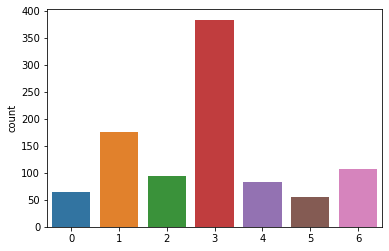

In [34]:
sn.countplot(y_train)

In [35]:
(y_train==3).sum()/len(y_train)

0.39751552795031053

We will use the same metrics than on the previous section. 
Also, we will check how much *Time* is taking our models to train.

In [36]:
metrics = ['F-score (cv)', 'Precision (cv)','Recall (cv)', 'Accuracy']

results_df = pd.DataFrame(index=['KNN'],columns=metrics + ['Time(s)'])
results_df

,F-score (cv),Precision (cv),Recall (cv),Accuracy,Time(s)
KNN,NaN,NaN,NaN,NaN,NaN


### Baseline: KNN

We will use knn as a baseline, because is a very fast model to train.

In [37]:
init_time = time()
myknn = KNeighborsClassifier(n_neighbors=5)
myknn.fit(X_train, y_train)

training_time = time()-init_time
print(timedelta(seconds=training_time))


cross_val_results = pd.DataFrame(cross_validate(myknn , X_train, y_train, cv = 5, scoring = [ 'f1_macro', 'precision_macro', 'recall_macro', 'accuracy'] ))

results_df.loc['KNN',metrics] = cross_val_results[['test_f1_macro',
       'test_precision_macro', 'test_recall_macro','test_accuracy']].mean().values

results_df.loc['KNN','Time(s)'] = training_time

results_df

KNeighborsClassifier()

0:00:00.008618


,F-score (cv),Precision (cv),Recall (cv),Accuracy,Time(s)
KNN,0.42,0.508,0.406,0.557,0.009


We obtain quite bad results with this model. Lets see with the MLP. 

### MLP

We are going to use an arbitrary hyperparameter configuration just to see how the model behaves. Is it slow? Is it good?

In [38]:
init_time = time()
model_nnet = MLPClassifier(hidden_layer_sizes=[5],
                           alpha=0.01,
                           activation='logistic',
                           max_iter=200,
                           solver='lbfgs',random_state=42)
model_nnet.fit(X_train,y_train);

training_time = time()-init_time
print(timedelta(seconds=training_time))

cross_val_results = pd.DataFrame(cross_validate(model_nnet , X_train, y_train, cv = 5, 
                                                scoring = [ 'f1_macro', 'precision_macro', 'recall_macro', 'accuracy'] ))

results_df.loc['MLP[5]-0.01',metrics] = cross_val_results[['test_f1_macro',
       'test_precision_macro', 'test_recall_macro','test_accuracy']].mean().values

results_df.loc['MLP[5]-0.01','Time(s)'] = training_time

results_df.sort_values(by='F-score (cv)', ascending=False)

MLPClassifier(activation='logistic', alpha=0.01, hidden_layer_sizes=[5],
              random_state=42, solver='lbfgs')

0:00:01.194825


,F-score (cv),Precision (cv),Recall (cv),Accuracy,Time(s)
MLP[5]-0.01,0.67,0.681,0.674,0.735,1.195
KNN,0.42,0.508,0.406,0.557,0.009


It gives better results but it is several times slower than the knn. 

If we wanted to try different hyperparameters we would need a lot of time. 

### PCA

Lets try another strategy instead. We can use PCA to reduce the dimensionality of the data. This way the training of the model would be faster, and might reduce the noise in the data.


First lets see how many components do we need.

In [39]:
pca = PCA().fit(X_train)

n_components =(pca.explained_variance_ratio_.cumsum() < 0.99).sum()
n_components

339

With just 339 of the variables, we could maintain 99 % of the variance of the data. Thas a huge reduction from the original 1850.

In [40]:
pca = PCA(n_components=n_components).fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

#### KNN
Lets see how affects our smaller data to the knn results.

In [41]:
init_time = time()
myknn = KNeighborsClassifier(n_neighbors=5)
myknn.fit(X_train_pca, y_train)

training_time = time()-init_time
print(timedelta(seconds=training_time))

cross_val_results = pd.DataFrame(cross_validate(myknn , X_train_pca, y_train, cv = 5, scoring = [ 'f1_macro', 'precision_macro', 'recall_macro', 'accuracy'] ))

results_df.loc['KNN-PCA',metrics] = cross_val_results[['test_f1_macro',
       'test_precision_macro', 'test_recall_macro','test_accuracy']].mean().values

results_df.loc['KNN-PCA','Time(s)'] = training_time

results_df.sort_values(by='F-score (cv)', ascending=False)

KNeighborsClassifier()

0:00:00.006685


,F-score (cv),Precision (cv),Recall (cv),Accuracy,Time(s)
MLP[5]-0.01,0.67,0.681,0.674,0.735,1.195
KNN-PCA,0.422,0.508,0.408,0.557,0.007
KNN,0.42,0.508,0.406,0.557,0.009


We are obtaining the same results with a fraction of the time. This is a good sign.

#### MLP


In [42]:
init_time = time()
model_nnet = MLPClassifier(hidden_layer_sizes=[5],
                           alpha=0.01,
                           activation='logistic',
                           max_iter=200,
                           solver='lbfgs',random_state=42)
model_nnet.fit(X_train_pca,y_train);

training_time = time()-init_time
print(timedelta(seconds=training_time))


cross_val_results = pd.DataFrame(cross_validate(model_nnet , X_train_pca, y_train, cv = 5, 
                                                scoring = [ 'f1_macro', 'precision_macro', 'recall_macro', 'accuracy'] ))

results_df.loc['MLP[5]-0.01-PCA',metrics] = cross_val_results[['test_f1_macro',
       'test_precision_macro', 'test_recall_macro','test_accuracy']].mean().values

results_df.loc['MLP[5]-0.01-PCA','Time(s)'] = training_time

results_df.sort_values(by='F-score (cv)', ascending=False)

MLPClassifier(activation='logistic', alpha=0.01, hidden_layer_sizes=[5],
              random_state=42, solver='lbfgs')

0:00:00.386152


,F-score (cv),Precision (cv),Recall (cv),Accuracy,Time(s)
MLP[5]-0.01,0.67,0.681,0.674,0.735,1.195
MLP[5]-0.01-PCA,0.637,0.659,0.638,0.727,0.386
KNN-PCA,0.422,0.508,0.408,0.557,0.007
KNN,0.42,0.508,0.406,0.557,0.009


The MLP has lost a bit on our metrics but is faster, now we can try to improve its results using cross-validation.

We will use the firs technique that we comented before, as the model takes longer to train. 

In [43]:
sizes = [2*i for i in range(1,4)]
sizes = sizes + [[2*i,2*i] for i in range(1,4)]
sizes

[2, 4, 6, [2, 2], [4, 4], [6, 6]]

If we do 5-cv with 6 layer configuration and we spend 1.5 seconds with each training, we *should* spend approximately 45 seconds with the CV process. If all the architectures took the same time to train. 

If we had done it without the pca we would take more than two minutes. 

Note that these times where computed with my machine, it will probably change depending on your computer.

In [44]:
init_time = time()

model_nnet = MLPClassifier(alpha=0,
                           activation='logistic',
                           hidden_layer_sizes=2,
                           max_iter=500,
                           solver='lbfgs',random_state=42)

trc = GridSearchCV(estimator=model_nnet, 
                   param_grid ={'hidden_layer_sizes':sizes},
                   scoring=['f1_macro',
       'precision_macro', 'recall_macro','accuracy'],
                   cv=5,
                   return_train_score=True,
                  refit='f1_macro')
model_5CV = trc.fit(X_train_pca,y_train)
model_5CV.best_score_
model_5CV.best_params_
print(timedelta(seconds=(time()-init_time)))

0.6593068154744219

{'hidden_layer_sizes': 6}

0:00:19.294319


It took almost 1:21 minutes. 

The best architecture found is [6]

In [45]:
pd.DataFrame(model_5CV.cv_results_).loc[:,['mean_fit_time','param_hidden_layer_sizes', 'mean_test_f1_macro',
       'mean_test_precision_macro', 'mean_test_recall_macro','mean_test_accuracy']].sort_values(by='mean_test_f1_macro',ascending=False)

,mean_fit_time,param_hidden_layer_sizes,mean_test_f1_macro,mean_test_precision_macro,mean_test_recall_macro,mean_test_accuracy
2,0.643,6,0.659,0.676,0.663,0.730
1,0.549,4,0.600,0.615,0.621,0.690
5,0.715,"[6, 6]",0.507,0.501,0.532,0.629
4,0.645,"[4, 4]",0.488,0.485,0.516,0.640
3,0.594,"[2, 2]",0.328,0.323,0.404,0.543
0,0.542,2,0.304,0.296,0.361,0.579


We can see that each training took more time than the one we used to estimate. This might be because the number of neurons of the architectures. 

Now lets see the decays.

In [46]:
decays = [0, 10, 1, 0.1, 0.01, 0.001]
decays

[0, 10, 1, 0.1, 0.01, 0.001]

In [47]:
init_time = time()

model_nnet = MLPClassifier(alpha=0,
                           activation='logistic',
                           hidden_layer_sizes=[6],
                           max_iter=500,
                           solver='lbfgs',random_state=42)

trc = GridSearchCV(estimator=model_nnet, 
                   param_grid ={'alpha': decays},
                   scoring=['f1_macro', 'precision_macro', 'recall_macro','accuracy'],
                   cv=5,
                   return_train_score=True,
                  refit='f1_macro')
model_5CV = trc.fit(X_train_pca,y_train)
model_5CV.best_score_
model_5CV.best_params_
print(timedelta(seconds=(time()-init_time)))

0.7844969531414708

{'alpha': 1}

0:00:19.582486


In [48]:
pd.DataFrame(model_5CV.cv_results_).loc[:,['mean_fit_time','param_alpha', 'mean_test_f1_macro',
       'mean_test_precision_macro', 'mean_test_recall_macro','mean_test_accuracy']].sort_values(by='mean_test_f1_macro',ascending=False)

,mean_fit_time,param_alpha,mean_test_f1_macro,mean_test_precision_macro,mean_test_recall_macro,mean_test_accuracy
2,0.640,1,0.784,0.814,0.770,0.823
1,0.533,10,0.765,0.819,0.740,0.817
3,0.628,0.1,0.744,0.755,0.739,0.788
4,0.629,0.01,0.685,0.702,0.686,0.752
5,0.623,0.001,0.678,0.699,0.676,0.748
0,0.695,0,0.659,0.676,0.663,0.730


Now that we have found our best MLP (among these configurations). Lets check it.

In [49]:
init_time = time()
model_nnet = MLPClassifier(hidden_layer_sizes=[6],
                           alpha=1,
                           activation='logistic',
                           max_iter=200,
                           solver='lbfgs',random_state=42)
model_nnet.fit(X_train_pca,y_train);

training_time = time()-init_time
print(timedelta(seconds=training_time))

cross_val_results = pd.DataFrame(cross_validate(model_nnet , X_train_pca, y_train, cv = 5, scoring = [ 'f1_macro', 'precision_macro', 'recall_macro', 'accuracy'] ))

results_df.loc['MLP[6]-1-PCA',metrics] = cross_val_results[['test_f1_macro',
       'test_precision_macro', 'test_recall_macro','test_accuracy']].mean().values

results_df.loc['MLP[6]-1-PCA','Time(s)'] = training_time

results_df.sort_values(by='F-score (cv)', ascending=False)


MLPClassifier(activation='logistic', alpha=1, hidden_layer_sizes=[6],
              random_state=42, solver='lbfgs')

0:00:00.302895


,F-score (cv),Precision (cv),Recall (cv),Accuracy,Time(s)
MLP[6]-1-PCA,0.786,0.809,0.775,0.823,0.303
MLP[5]-0.01,0.67,0.681,0.674,0.735,1.195
MLP[5]-0.01-PCA,0.637,0.659,0.638,0.727,0.386
KNN-PCA,0.422,0.508,0.408,0.557,0.007
KNN,0.42,0.508,0.406,0.557,0.009


Now that we have choosen our best model. We can check if it generalizes using the test set.

In [50]:

y_pred = model_nnet.predict(X_test_pca)

y_test = pd.Series(y_test).map({i:t for i,t in enumerate(target_names)})
y_pred = pd.Series(y_pred).map({i:t for i,t in enumerate(target_names)})

confusion(y_test,y_pred)

print(classification_report(y_test,y_pred))

predicted,Ariel Sharon,Colin Powell,Donald Rumsfeld,George W Bush,Gerhard Schroeder,Hugo Chavez,Tony Blair
target,,,,,,,
Ariel Sharon,8,1,3,1,0,0,0
Colin Powell,2,52,3,2,0,1,0
Donald Rumsfeld,1,1,20,3,2,0,0
George W Bush,1,8,4,126,2,1,4
Gerhard Schroeder,0,1,0,0,20,2,2
Hugo Chavez,0,2,0,2,3,7,1
Tony Blair,0,2,1,2,3,1,27


                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.62      0.64        13
     Colin Powell       0.78      0.87      0.82        60
  Donald Rumsfeld       0.65      0.74      0.69        27
    George W Bush       0.93      0.86      0.89       146
Gerhard Schroeder       0.67      0.80      0.73        25
      Hugo Chavez       0.58      0.47      0.52        15
       Tony Blair       0.79      0.75      0.77        36

         accuracy                           0.81       322
        macro avg       0.72      0.73      0.72       322
     weighted avg       0.81      0.81      0.81       322



We have obtained quite good results, and the model generalizes so it also predicts acurately on the test set.